# Homework 4 (due Nov 8)

## Image quantization (40)

One popular use of the k-means algorithm is in image compression (see Murphy 11.4.2.6).  In general images are encoded as a grid of 3 8-bit integers (the red, green, and blue bands, each ranging from 0-255).  To use K-means to compress an image, K-means clustering is performed on the array of pixel values to obtain the K colors most that in some sense contain the most information.  The compressed image is generated by replacing each pixel value with the index of the nearest K-means cluster center.  When it is time to display the image, each pixel value is reconstructed by looking up the RGB value corresponding to its index.  This process is referred to as *Image quantization*.

Import an image of your choosing, and apply K-means based image quantization to it.  You can write the code for K-means yourself, adapt the code from the lecture, or you can use the scikit-learn implementation, which can be imported with the following command:

Compressed image after 5 rounds of K-Means


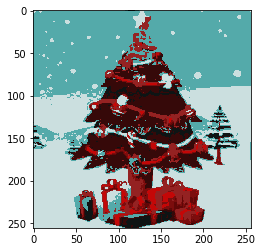

In [26]:
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

# Create a cluster class
class Cluster:
    def __init__(self, id, red, green, blue):
        self.id = id
        self.red = red
        self.green = green
        self.blue = blue
        
    def getId(self):
        return self.id
    
    def getRedMean(self):
        return self.red
    
    def getGreenMean(self):
        return self.green
    
    def getBlueMean(self):
        return self.blue
    
    def setRedMean(self, redMean):
        self.red = redMean
    
    def setGreenMean(self, greenMean):
        self.green = greenMean
    
    def setBlueMean(self, blueMean):
        self.blue = blueMean
        
    def recalculateMeans(self, pixels):
        totalMembers = 0
        sum_red = 0
        sum_blue = 0
        sum_green = 0
        for i in range(0, len(pixels)):
            if(pixels[i].getClassMembership() == self.id):
                sum_red += pixels[i].getRed()
                sum_blue += pixels[i].getBlue()
                sum_green += pixels[i].getGreen()
                totalMembers += 1
                
        self.red = sum_red/totalMembers
        self.blue = sum_blue/totalMembers
        self.green = sum_blue/totalMembers
                
    
# Create a pixel class
class Pixel:
    def __init__(self, index, red, green, blue):
        self.index = index
        self.red = red
        self.blue = blue
        self.green = green
        self.classMembership = 0
        
    def getRed(self):
        return self.red
    
    def getGreen(self):
        return self.green
    
    def getBlue(self):
        return self.blue

    def getClassMembership(self):
        return self.classMembership
  
    def setClassMembership(self, newClass):
        self.classMembership = newClass
    
    def getInfo(self):
        return str(self.index) + ": red[" + str(self.red) + "], green[" + str(self.green) + "], blue[" + str(self.blue) + "]"
    
    def getDistanceToCluster(self, cluster): # implement euclidean distance formula for 3 variables
        distRed = (self.red - cluster.getRedMean())**2
        distGreen = (self.green - cluster.getGreenMean())**2
        distBlue = (self.blue - cluster.getBlueMean())**2
        return math.sqrt(distRed + distGreen + distBlue)
    
    def reassignClassMembershipClosestCluster(self, clusters):
        distances = []
        for i in range(0, len(clusters)):
            distances.append(self.getDistanceToCluster(clusters[i]))
        self.classMembership = distances.index(min(distances))
        
    
def getPixelIndex(i, j, imageWidth):
    return (i*imageWidth) + j

# ***************************************
# This method accepts a flattened image and compresses it (use cluster mean rgb values)
# and then converts it from its flattened array form back to a 2d matrix
# ***************************************
def reformattImage(flattenedImage, imageWidth, imageHeight, clusters):
    image = []
    for i in range(0, imageHeight):
        image.append([])
        for j in range(0, imageWidth):
            pixel = flattenedImage[(imageWidth * (i - 1)) + j]
            cluster = clusters[pixel.getClassMembership()]
            image[i].append([int(cluster.getRedMean()), int(cluster.getGreenMean()), int(cluster.getBlueMean())])
    return image

    
# read in the image and get the width and height of the image
image = plt.imread('christmas.jpeg', 'RGB')
imageWidth = len(image[0])
imageHeight = len(image)

flattenedImage = []
# flatten the array
for i in range(0, len(image)):
    for j in range(0, len(image[0])):
        pixel = Pixel(getPixelIndex(i, j, imageWidth), image[i][j][0], image[i][j][1], image[i][j][2])
        flattenedImage.append(pixel)

m = len(flattenedImage) # number of datapoints
N = 8 # number of clusters
clusters = []

# Randomly assign initial classes to each pixel object
for i in range(0, m):
    flattenedImage[i].setClassMembership(np.random.randint(0, 8))
    
# Initialize and randomly assign mean values to each cluster
for i in range(0, N):
    randomRedMean = np.random.randint(0, 255)
    randomGreenMean = np.random.randint(0, 255)
    randomBlueMean = np.random.randint(0, 255)
    clusters.append(Cluster(i, randomRedMean, randomGreenMean, randomBlueMean))

# Head into the K-cluster loop!
for i in range(0, 5):
    # reassign class membership based on the closest cluster
    for i in range(0, len(flattenedImage)):
        flattenedImage[i].reassignClassMembershipClosestCluster(clusters)

    # update means for each cluster
    for i in range(0, N):
        clusters[i].recalculateMeans(flattenedImage)

# Now that we have calculated the cluster means, we need to compress the image by associating each 

print('Compressed image after 5 rounds of K-Means')
newImage = reformattImage(flattenedImage, imageWidth, imageHeight, clusters)
plt.imshow(newImage)

    

Original image:


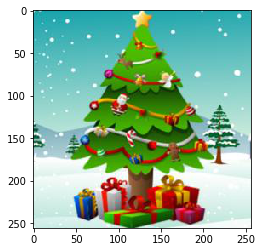

In [23]:
print('Original image:')
plt.imshow(image) # show the original image

**Use $k=2^3=8$ clusters**.  Display both the original image and the quantized version.  

**Please submit answers to the following questions to Assignment 4 on Moodle.**
1. Is the above compression technique "lossy", i.e. could you recover the original image from the compressed one?
2. (Grad students only) In theory, how much storage savings is achieved using this type of compression compared to an 8-bit, 3-channel uncompressed image? 

## Linear Regression

<img src="cricket.jpg" width=30%>
For centuries, it's been understood that the frequency of cricket chirps increases as temperature increases.  In this problem, you will determine the functional relationship between these two variables such that cricket chirps can be used as a thermometer. 

To begin, import the data file cricket.txt.  The first column is the temperature in degrees C, while the second column is the number of cricket chirps per 15 seconds.  Using scikit-learn's model selection tools, we can split the data into a training set, which will be used to train the model, and a test set, which will be used to validate the model's performance on data that was *not* used to train it.  

In [ ]:
data = np.loadtxt('crickets.txt')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[:,0], data[:,1], test_size=0.5, random_state=42)

### 1. Ordinary Least Squares (20)
Your first task is to define a function that will fit a polynomial of arbitrary degree to the data, subject to Tikhonov regularization.  To do this you will have to generate the Vandermonde matrix $X$, and solve the normal equations 
$$
(X^T X + \gamma \mathcal{I}) \mathbf{w} = X^T y,
$$
where $\mathbf{w}$ is the vector of polynomial coefficients.  Plot the data with the optimal polynomial of degree 1 (a line) overlain. 

In [ ]:
def fit_polynomial(X,y,d,gamma=0):
    """  Find the ordinary least squares fit of an independent 
        variable X to a dependent variable y"""
    X_vander = None #!
    W = None  #!
      
    return W

### 2. Overfitting (20)
With the above function in hand, now we will explore the effect of fitting higher degree polynomials to the data.  Fit the training data using polynomials from degree 1 to 15, without regularization (i.e. $\gamma=0$).  For each of these fits, record the resulting root mean square error in both the training and test data.  Plot both of these RMSE values as a function of polynomial degree (Using a logarithmic scale for RMSE is helpful).  **In a document that you submit to Assignment 4 on Moodle, describe the pattern that you see, and explain the reason behind the different behavior between the two curves.**  

In [ ]:
train_rmse = []
test_rmse = []
for d in range(1,15):
    # Use the function you generated above to fit a polynomial of degree d to the cricket data
    
    # Report the RMSE 
    X_vander_train = None  #!
    X_vander_test = None   #! 
    
    W = fit_polynomial(X_train,y,d)

    train_rmse.append(np.sqrt(np.sum((np.dot(X_vander_train,W) - y_train)**2)))
    test_rmse.append(np.sqrt(np.sum((np.dot(X_vander_test,W) - y_test)**2)))

plt.semilogy(train_rmse)
plt.semilogy(test_rmse)
plt.show()

### 3. Regularization(*) (20)
Fix the polynomial degree at 15, and now fit the training data for regularization parameter $\gamma \in [10^{-9},10^2]$ (you'll want to distribute these points in log-space; see below).  As above compute the RMSE in the training and test sets, and plot as a function of $\gamma$.  **In a document that you submit to Assignment 4 on Moodle, describe the pattern that you see, and explain the reason behind the different behavior between the two curves.**  

In [ ]:
train_rmse = []
test_rmse = []
gammas = np.logspace(-9,2,12)
d = 15
for gamma in gammas:
    # Use the function you generated above to fit a polynomial of degree d to the cricket data
    
    # Report the RMSE 
    X_vander_train = None  #!
    X_vander_test = None   #! 
    
    W = fit_polynomial(X_train,y,d,gamma=gamma)

    train_rmse.append(np.sqrt(np.sum((np.dot(X_vander_train,W) - y_train)**2)))
    test_rmse.append(np.sqrt(np.sum((np.dot(X_vander_test,W) - y_test)**2)))

plt.semilogy(train_rmse)
plt.semilogy(test_rmse)
plt.show()